# Portfolio-Exam (MADS-ML)

In [1]:
# Imports 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn import tree, metrics as ms
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler

# Define variable
random_seed = 1

# Task 1 – Story

As a data scientist, I'm working at a bank, and my task is to build a fraud detection classifier for credit card transactions. The bank was experiencing a rise in fraudulent activities, leading to financial losses and a damaged reputation. The experiment's purpose is to create a reliable system that could accurately detect fraud in credit card transactions, thus minimizing losses and enhancing customer trust. 
Therefore, I'll try three different machine learning approaches — decision trees, k-nearest-neighbours and support vector machines — using a dataset of labeled transactions.
After that, I'll determine the approach I would use in production and fine-tune it to create a precise fraud detection classifier.


# Task 2 – The Data

In [2]:
# load the dataset using local path
df = pd.read_csv(r'C:\Users\Max\Desktop\Data_Science_Kiel\Machine Learning\Portfolio_exam\creditcard.csv')

The description on kaggle:

"The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes <b> value 1 in case of fraud and 0 otherwise. </b>", Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv

This dataset is suitable for the project because it includes information about credit card transactions, and they are labeled as fraudulent or not.

# Task 3 – IDA

In [3]:
def calc_dist_class(data, name, binary):
    """Calculate the distribution of the classes in the dataset.
    Args:
        data (dataframe): dataset.
        name (string): name of the dataset.
        binary (bool): True if the dataset is binary, False if not.
    Returns:
        None
    """
    if binary == True:
        class_counts = np.bincount(data)
    else: 
        class_counts = data['Class'].value_counts()

    class_frequencies = np.array(class_counts) / len(data)
    print(f'The number of no fraud transactions in {name} is: {class_counts[0]} and the number of fraud transactions in {name} is: {class_counts[1]}.')
    print(f'The percentage of no fraud transactions in {name} is: {class_frequencies[0]*100:.3f}% and percentage of fraud transactions in {name} is: {class_frequencies[1]*100:.3f}%.')

In [4]:
# Define a function to do initial data analysis (IDA)
def initial_data_analysis(df,name):
    """
    Gives information about the dataframe for a quick overview.
    Args:
        df (pandas.DataFrame): The dataframe to be analysed.
        name (str): The name of the dataframe.
    Returns:
        None
    """
    print(f'Initial data analysis for {name}:\n')
    print(f'Shape: {df.shape}\n')

    # look at distribution of the target variable
    calc_dist_class(df, name, False)

    column_name = []
    dtype = []
    count = []
    unique = []
    missing_values = []
    # create a list of column names, data types, number of non-null values, number of unique values and number of missing values
    for column in df.columns:
        column_name.append(column)
        dtype.append(df[column].dtype)
        count.append(len(df[column]))
        unique.append(len(df[column].unique()))
        missing_values.append(df[column].isna().sum())
    # create a dataframe consisting of the lists
    overview_values = pd.DataFrame({'column_name': column_name,'dtype': dtype,'count': count,'unique': unique,'missing_values': missing_values})
    display(overview_values)
    # sum up all the values in missing_values to get the total number of missing values
    missing_val  =  sum(missing_values) #Sum of missing values
    print(f'Sum of missing values: {missing_val}\n') 
    total_cells = np.product(df.shape) # get total number of values in the dataframe
    print(f'Percentage of null values: {missing_val/total_cells*100:.2f}%\n') 

    #check for duplicates 
    print('Number of duplicates of each class:')
    print(df[df.duplicated()].groupby('Class')['Class'].count())
    print(' ')

    # calculate the percentage of the of the number of duplicates of each class
    print('Percentage of duplicates of each class:')
    print(df[df.duplicated()].groupby('Class')['Class'].count()/df['Class'].value_counts()*100)
    print(' ')
    
    print('Head:')
    display( df.head())

    # get descriptive statistics for the numerical columns
    print('Discribe:')
    display(df.describe().round(2)) 
    print(' ') # do a linebreak


In [5]:
initial_data_analysis(df,'creditcard.csv')

Initial data analysis for creditcard.csv:

Shape: (284807, 31)

The number of no fraud transactions in creditcard.csv is: 284315 and number of fraud transactions in creditcard.csv is: 492.
The percentage of no fraud transactions in creditcard.csv is: 99.827% and percentage of fraud transactions in creditcard.csv is: 0.173%.


,column_name,dtype,count,unique,missing_values
0,Time,float64,284807,124592,0
1,V1,float64,284807,275663,0
2,V2,float64,284807,275663,0
3,V3,float64,284807,275663,0
4,V4,float64,284807,275663,0
5,V5,float64,284807,275663,0
6,V6,float64,284807,275663,0
7,V7,float64,284807,275663,0
8,V8,float64,284807,275663,0
9,V9,float64,284807,275663,0


Sum of missing values: 0

Percentage of null values: 0.00%

Number of duplicates of each class:
Class
0    1062
1      19
Name: Class, dtype: int64
 
Percentage of duplicates of each class:
Class
0    0.373529
1    3.861789
dtype: float64
 
Head:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Discribe:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


### Visualize the distribution of the classes

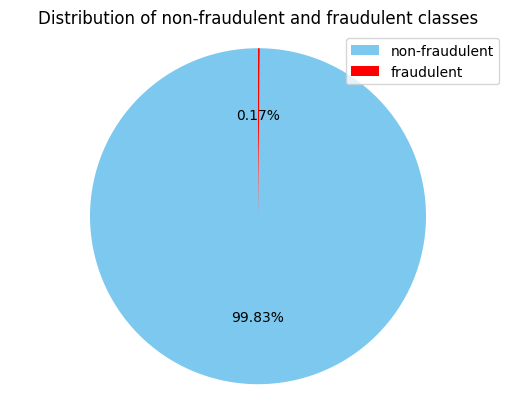

In [6]:
# create a pie chart to show the class distribution

# count the number of samples in each class
class_counts = df['Class'].value_counts()

# define colors for the pie slices
colors = ['#7cc8ee', 'red']

# create a pie chart
fig, ax = plt.subplots()
pie = ax.pie(class_counts, labels=['non-fraudulent', 'fraudulent'], colors=colors, autopct='%1.2f%%', startangle=90)

# set the label color to white
for label in pie[1]:
    label.set_color('white')

# add a legend
ax.legend(pie[0], ['non-fraudulent', 'fraudulent'], loc='upper right')

# add a title
ax.set_title('Distribution of non-fraudulent and fraudulent classes')

# set the aspect ratio to make it a circle
ax.axis('equal')

# show the plot
plt.show()


This pie chart illustrates the imbalance between the two classes. We can clearly see, that there are just a few fraudulent transactions compared to the non-fraudulent transactions. 

The imbalance is a difficulty we need to handle, while training and evaluating the classifier. 


### Look at the distribution of the time

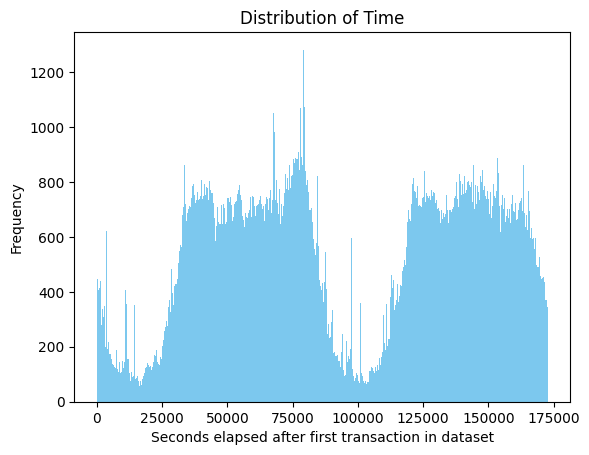

In [7]:
# show distribution of the Time 
fig, ax = plt.subplots()
# square root rule for choosing the number of bins
bin_size = int(np.sqrt(len(df['Time'])))
ax.hist(df['Time'], bins=bin_size , color='#7cc8ee')
ax.set_title('Distribution of Time')
ax.set_xlabel('Seconds elapsed after first transaction in dataset')
ax.set_ylabel('Frequency')
plt.show()

The plot shows that there are two time slots with a lower number of transactions. The number of transactionsis stays relatively constant between ~25000 and ~80000 and ~120000 and ~170000 seconds after the first transaction in the dataset.

### Look at the distribution of the Amount

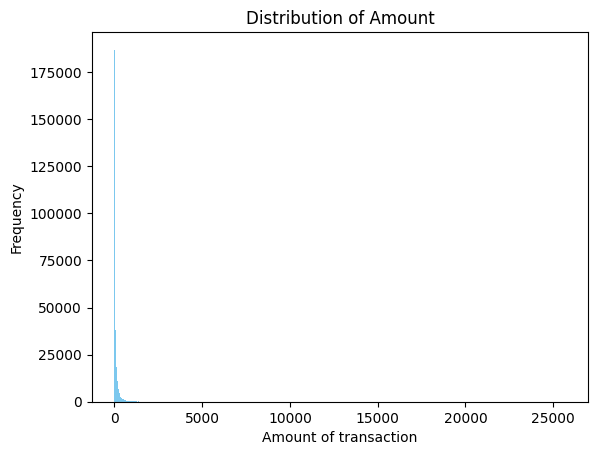

In [8]:
# plot the distribution of the Amount
fig, ax = plt.subplots()
# square root rule for choosing the number of bins
bin_size = int(np.sqrt(len(df['Amount'])))
ax.hist(df['Amount'], bins=bin_size , color='#7cc8ee')
ax.set_title('Distribution of Amount')
ax.set_xlabel('Amount of transaction')
ax.set_ylabel('Frequency')
plt.show()

We have no further information about the currency of the transactions.
Since we know the card holders are based in Europe, the currency is probably Euro.
Also, we have no information on whether the amounts are all in the same currency.
The actual currency is not important for our analysis, as long as the currency is the same for all transactions.
We assume that this is the case. 

The histogram shows that most of the transactions are close to zero. 
Because there the maximum amount is 25691 and the mean is 88 with a standart diviation of 250, the bar plot looks quiet empty.
By looking at the Initial data analysis from Task 3, we can see, that 75% of the transactions have a amount lower or equal than 77.

To get a better impression of the distribution of the Amount, we look at the distribution of each class separately.

In [9]:
display(df.groupby('Class')['Amount'].describe().round(2))


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.29,250.11,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.21,256.68,0.0,1.00,9.25,105.89,2125.87


The maximum for the non-fraudulent class is 12 times higher then the maximum for fraudulent class. Also for the lower 50% of the transaction the amount of the fraudulent class is more then half then the amount of the non-fraudulent class

# Task 4 – EDA, Preprocessing

### Time:

In [10]:
# get type of each column Time 
print(df['Time'].dtype)

float64


The column "Time" is of type int64. 
For the moment, we will leave it as it is.
If the following machine learning approaches do not lead to satisfying results, we will try to convert the time column.

From Task 3 - IDA, we know that the dataset has no missing values.
Since we don't know what the features V1 to V28 really mean, we can't do any further processing on them.


### Duplicates:

From Task 3 - IDA, we know that there are 1081 duplicates. 19 belong to class 0 and 1062 belong to class 1.
The percentage of duplicates in each class is 0.37%  for class 0 and 3.86% for class 1.
Because we don't know what the features V1 to V28 are, we can not say if the duplicates are meaningful or not. From the information that is given, it is possible that there are transactions at the same time and with the same amount. Therefore, we keep the duplicates. And as a data scientist at a bank, I should investigate the reason for the duplicates.

### Create a subset and define target and features:  

Because of the size of the data set, the runtime became extremely long. Therefore, I will use a subset for Task 5  and Task 6.
For Task 7 - Nested Cross Validation and Task 8 - Final Production Model I will use the whole data set. There, it's possible to use the whole data set and still get a reasonable runtime because undersampling is used. 
Usually the same data set should be used for all tasks, and several imbalance handling techniques should also be used (here only undersampling is used).

To create the subset of the data, we will use the train_test_split function from sklearn.
We use the stratify parameter to ensure that the class distribution stays the same.
Also, we use the random_state parameter to make it reproducible.

In [11]:
# Define target and features for the full dataset and the subset

# Full dataset:
target = df['Class'] # define target variable
features = df.drop(['Class'], axis=1) # define features

# Subset:
# create a stratified subset 
subset_size = 0.1 # set subset size 
_, features_sub, _, target_sub = train_test_split(features, target, test_size=subset_size, random_state=random_seed, stratify=target)

# Task 5 – A First Impression

To get a first impression, a subset is used so that the computing time remains moderate.

In [12]:
# Create a single train-test split with stratification using the subset
X_train, X_test, y_train, y_test = train_test_split(features_sub, target_sub, test_size=0.4, random_state=random_seed, stratify=target_sub, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17088, 30), (11393, 30), (17088,), (11393,))

In [13]:
# Scale the data
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)# fit the scaler to the training data and transform it
X_test_sc = scaler.transform(X_test) # transform the test data (no fitting)

### Determine a baseline:

In [14]:
dummy_clf = DummyClassifier(strategy="uniform",random_state=random_seed)
dummy_clf.fit(X_train_sc, y_train)
y_test_pred = dummy_clf.predict(X_test_sc)

In [15]:
# performance of the dummy classifier:
# accuracy
acc = ms.accuracy_score(y_test, y_test_pred)
print(f' The dummy classifier accuracy = {round(acc, 3)}')

 The dummy classifier accuracy = 0.497


In [16]:
#get number of samples in each class
class_counts = np.bincount(y_test)
print(f'Number of samples in each class: {class_counts}')

Number of samples in each class: [11373    20]


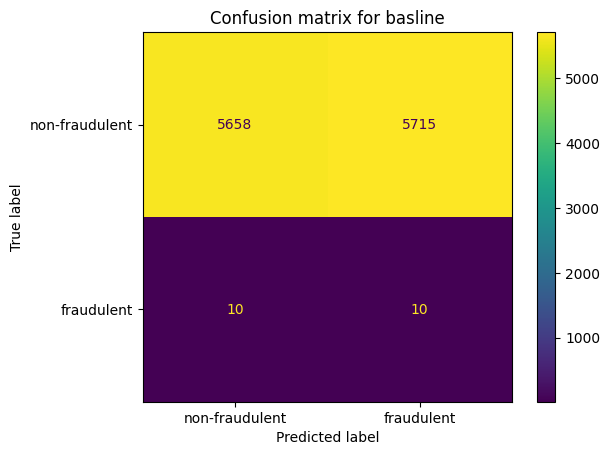

In [17]:
# Plot the confusion matrix
ms.ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred)
plt.title('Confusion matrix for basline') # add a title
#add name for classes
plt.xticks([0,1],['non-fraudulent','fraudulent'])
plt.yticks([0,1],['non-fraudulent','fraudulent'])
plt.show()

The accuracy of the dummy classifier is misleading because the dataset is highly imbalanced and the accuracy doesn't respect the class distribution. 
By looking at the confusion matrix, it becomes clear that only half of the positive class is predicted correctly. And a bit less than half of the negative class is predicted correctly.

Also, the classifier predicted (5715 + 10) times a positive class, but only 10 times it was actually a positive class.
The negative class was predicted (5658 + 10) times, of which only 10 were wrong.

When dealing with imbalanced data, accuracy is not a good choice for evaluating the model.
Because we are highly interested in predicting the positive class, it's better to use the f1 measure, which is used in the following.

In [18]:
# Precision
precision_baseline = ms.precision_score(y_test, y_test_pred)
print(f'Precision: {round(precision_baseline,3)}')

# Recall
recall_baseline = ms.recall_score(y_test, y_test_pred)
print(f'Recall: {round(recall_baseline,3)}')

# F1 measure 
f_one_baseline = ms.f1_score(y_test, y_test_pred)
print(f'F1 score: {round(f_one_baseline,3)}')

# balanced accuracy
balanced_acc_baseline = ms.balanced_accuracy_score(y_test, y_test_pred)
print(f'Balanced accuracy: {round(balanced_acc_baseline,3)}')

Precision: 0.002
Recall: 0.5
F1 score: 0.003
Balanced accuracy: 0.499


The precision of 0.002 means that 0.2% of the transactions that the dummy classifier predicted as fraudulent or non-fraudulent were actually correctly predicted.

The recall of 0.5 means that 50% of the fraudulent and non-fraudulent transactions were recognized as fraudulent or non-fraudulent by the dummy classifier.

The f1 score of 0.003 combines precision and recall into a single metric. And shows that the dummy classifier is not good at detecting fraudulent transactions.

Balanced accuracy is not a good metric here because the data set is highly imbalanced. And balanced accuracy treats all classes equally, regardless of their frequency in the dataset. So the majority class dominates the evaluation, so the result is misleading.

### Get a first impression 

To get a first impression of the classifiers used in this experiment, the performance with the default parameters and the split from above is considered.


#### Decition Tree:

In [19]:
# fit the decision tree clf with the default parameters 
clf = tree.DecisionTreeClassifier(random_state=random_seed)
clf = clf.fit(X_train, y_train)# no scaling needed for decision trees
y_test_pred = clf.predict(X_test)

In [20]:
# Performance of the kNN classifier:

# Precision
precision_dt = ms.precision_score(y_test, y_test_pred)
print(f'Precision: {round(precision_dt,4)}')

# Recall
recall_dt = ms.recall_score(y_test, y_test_pred)
print(f'Recall: {round(recall_dt,4)}')

# F1 measure 
f_one_dt = ms.f1_score(y_test, y_test_pred)
print(f'F1 score: {round(f_one_dt,4)}')

Precision: 0.68
Recall: 0.85
F1 score: 0.7556


The performance of the decision tree classifier is better than the dummy classifier, because the precision of 0.68 is way better than the precision of the dummy classifier. That means more elements that are predicted as non-fraudulent or fraudulent are actually non-fraudulent or fraudulent.


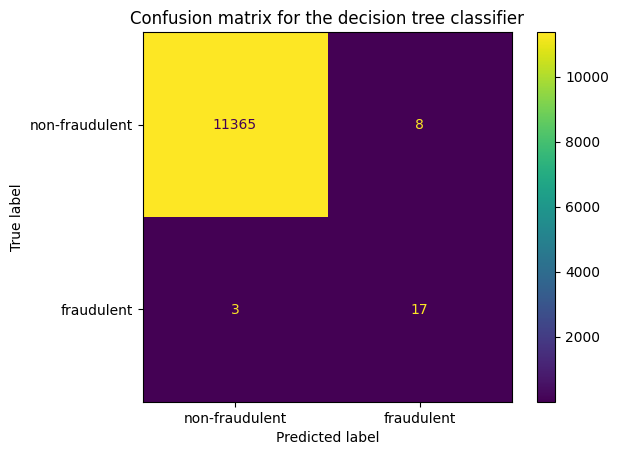

In [21]:
# plot the confusion matrix
ms.ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred) 
plt.title('Confusion matrix for the decision tree classifier') # add a title
#add name for classes
plt.xticks([0,1],['non-fraudulent','fraudulent'])
plt.yticks([0,1],['non-fraudulent','fraudulent'])
plt.show()

By looking at the confusion matrix, it's becoming clear that the Decision Tree Classifier has already performed quite well. Only 3 of the 20 fraudulent transactions were detected as non-fraudulent, and the other 17 were classified correctly. 

#### KNN:

In [22]:
# fit the kNN clf with the default parameters 
clf= KNeighborsClassifier() # no parameters random_state available for this classifier
clf.fit(X_train_sc, y_train)
y_test_pred = clf.predict(X_test_sc)

In [23]:
# Performance of the kNN classifier:

# Precision
precision_knn = ms.precision_score(y_test, y_test_pred)
print(f'Precision: {round(precision_knn,4)}')

# Recall
recall_knn = ms.recall_score(y_test, y_test_pred)
print(f'Recall: {round(recall_knn,4)}')

# F1 measure 
f_one_knn = ms.f1_score(y_test, y_test_pred)
print(f'F1 score: {round(f_one_knn,4)}')

Precision: 0.875
Recall: 0.7
F1 score: 0.7778


The kNN classifier also performed quite well. Compared to the decision tree classifier, the precision is higher and the recall is lower. 
The f1 score is a bit higher than the one of the decision tree classifier and dramatically higher than the one of the dummy classifier.

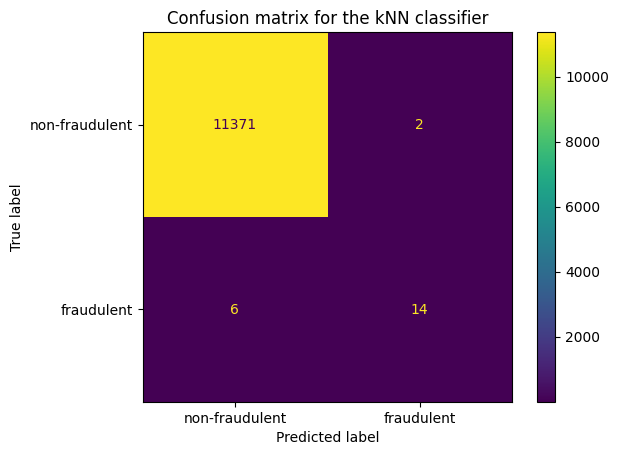

In [24]:
# Look at the confusion matrix
ms.ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred)
plt.title('Confusion matrix for the kNN classifier') # add a title
#add name for classes
plt.xticks([0,1],['non-fraudulent','fraudulent'])
plt.yticks([0,1],['non-fraudulent','fraudulent'])
plt.show()

The confusion matrix visualizes the performance of the kNN classifier. Compared to the decision tree classifier, the kNN classifier classified fewer fraudulent transactions correctly. But more non-fraudulent transactions are classified correctly. Compared to the baseline, the kNN classifier also performed way better.


#### SVM:

In [25]:
# fit the SVM clf with the default parameters
clf = SVC(random_state=random_seed)
clf.fit(X_train_sc, y_train)
y_test_pred = clf.predict(X_test_sc)

In [26]:
# Performance of the kNN classifier:

# Precision
precision_svm = ms.precision_score(y_test, y_test_pred)
print(f'Precision: {round(precision_svm,4)}')

# Recall
recall_svm = ms.recall_score(y_test, y_test_pred)
print(f'Recall: {round(recall_svm,4)}')

# F1 measure 
f_one_svm = ms.f1_score(y_test, y_test_pred)
print(f'F1 score: {round(f_one_svm,4)}')

Precision: 0.8824
Recall: 0.75
F1 score: 0.8108


The f1 score of 0.81 is the highest result so far.

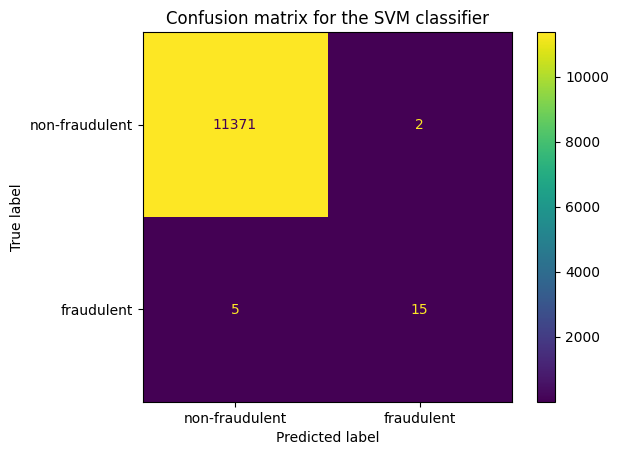

In [27]:
# Look at the confusion matrix
ms.ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred)
plt.title('Confusion matrix for the SVM classifier') # add a title
#add name for classes
plt.xticks([0,1],['non-fraudulent','fraudulent'])
plt.yticks([0,1],['non-fraudulent','fraudulent'])
plt.show()

Considering the confusion matrices, one more fraud transaction is classified correctly, as was the case for the kNN classifier. And the number of correct and incorrect classifications of non-fraudulent transactions is the same as for the kNN classifier. 



## Summary of the first impression 

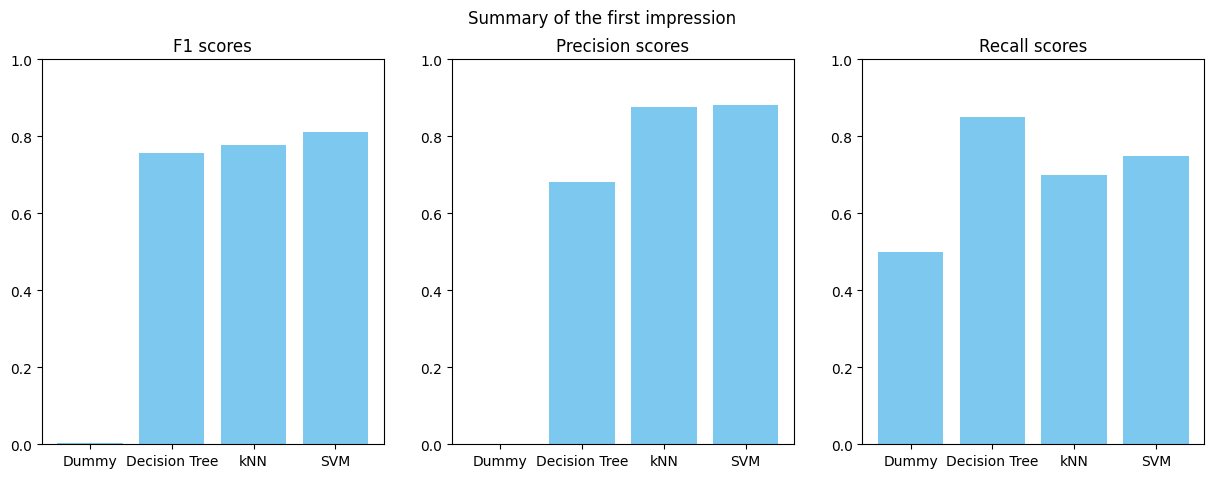

In [28]:
# barplot of the F1 scores
# create a list of the F1 scores
f1_scores = [f_one_baseline, f_one_dt, f_one_knn, f_one_svm]
precision_scores = [precision_baseline, precision_dt, precision_knn, precision_svm]
recall_scores = [recall_baseline, recall_dt, recall_knn, recall_svm]
# create a list of the classifiers
classifiers = ['Dummy', 'Decision Tree', 'kNN', 'SVM']
# create three subplots in one row 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# plot the F1 scores
ax1.bar(classifiers, f1_scores, color='#7cc8ee')
ax1.set_title('F1 scores')
ax1.set_ylim(0, 1)
# plot the precision scores
ax2.bar(classifiers, precision_scores, color='#7cc8ee')
ax2.set_title('Precision scores')
ax2.set_ylim(0, 1)
# plot the recall scores
ax3.bar(classifiers, recall_scores, color='#7cc8ee')
ax3.set_title('Recall scores')
ax3.set_ylim(0, 1)
# add a title to the figure
fig.suptitle('Summary of the first impression ')
# show the plot
plt.show()


It's obvious that the dummy classifier performs very poorly. The other three classifiers are quite good. They all have nearly the same F1 score. The main difference is that the Decision Tree classifier has worse precision than the other two classifiers (fewer elements identified as being of class $C_i$ actually were of $C_i$). But therefor the decision tree classifier has a better recall (more elements of class $C_i$ have been recognized as $C_i$).

From our first impression, we should keep in mind that only a subset was used.

# Task 6 – Algorithms and their Parameters

In the following <b> Decision Trees, k-Nearest-Neighbors  </b> and <b> Support Vector Machines </b> are used.
For each of them, validation diagrams are created to get an impression of the hyperparameter influence.
Afterward, a reasonable choice of hyperparameters is selected for the nested cross validation in task 7.


## Decision Trees

The split form above is used but not the scaled data because feature scaling is not necessary for decision trees.


To create a decision tree, the following parameters are used:
- criterion: The function to measure the quality of a split.
- max_depth: The maximum depth of the tree. 

In [29]:
# Define an empty DataFrame
df_evaluation_dt = pd.DataFrame(columns=['f_one_score', 'precision', 'recall', 'criterion', 'max_depth','actual_tree_depth'])

# set the parameters to be tested
criterions = ['gini', 'entropy']
maximum_depth = 25
max_depths = range(1,maximum_depth+1)

# try out all combinations of the parameters
for criterion in criterions:
    for max_depth in max_depths:
                
                # train the decision tree classifier
                clf = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth,random_state=random_seed)
                clf = clf.fit(X_train, y_train) # no scaling needed for decision trees
                y_test_pred = clf.predict(X_test)
              
                # Precision
                precision = ms.precision_score(y_test, y_test_pred, zero_division=1) # set zero_division=1 to avoid warnings

                # Recall
                recall = ms.recall_score(y_test, y_test_pred)

                # F1 measure 
                f_one = ms.f1_score(y_test, y_test_pred)

                # Create a dictionary with the values
                row_dict = {'f_one_score': f_one,
                            'precision': precision,
                            'recall': recall, 
                            'criterion': criterion,
                            'max_depth': max_depth,
                            'actual_tree_depth': clf.tree_.max_depth}
                
                # Concat the row to the DataFrame
                df_evaluation_dt = pd.concat([df_evaluation_dt, pd.DataFrame([row_dict])], ignore_index=True)

In [30]:
# get rows with 3 highest F1 scores
df_evaluation_dt.nlargest(3, 'f_one_score')

,f_one_score,precision,recall,criterion,max_depth,actual_tree_depth
27,0.829268,0.809524,0.85,entropy,3,3
3,0.809524,0.772727,0.85,gini,4,4
4,0.772727,0.708333,0.85,gini,5,5


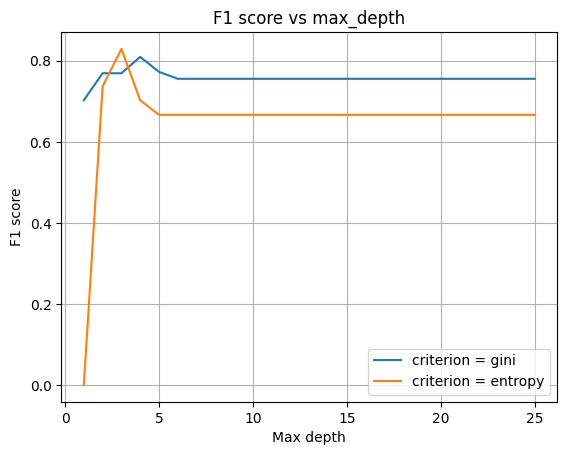

In [31]:
# Plot F1 score vs max_depth for gini and entropy 
fig, ax = plt.subplots()
ax.plot(df_evaluation_dt[df_evaluation_dt['criterion'] == 'gini']['max_depth'], df_evaluation_dt[df_evaluation_dt['criterion'] == 'gini']['f_one_score'], label='criterion = gini')
ax.plot(df_evaluation_dt[df_evaluation_dt['criterion'] == 'entropy']['max_depth'], df_evaluation_dt[df_evaluation_dt['criterion'] == 'entropy']['f_one_score'], label='criterion = entropy')
ax.set_xlabel('Max depth')
ax.set_ylabel('F1 score')
ax.set_title('F1 score vs max_depth')
ax.grid()
ax.legend()
plt.show()


The f1 score of the decision tree classifier is the highest for max_depth = 3 and entropy.

For max_depth greater than 6 the f1 score stays constant for both criterions.

Therefore, a range from 2 to 10 (a bit more than until 6) will be used for the grid search.
Because gini and entropy both yield high f1 scores, both criterions will be used for the grid search.

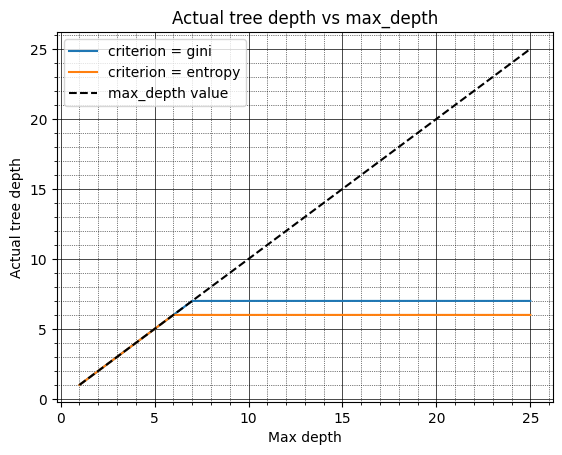

In [32]:
# Plot actual tree depth vs max_depth for gini and entropy
fig, ax = plt.subplots()
ax.plot(df_evaluation_dt[df_evaluation_dt['criterion'] == 'gini']['max_depth'], df_evaluation_dt[df_evaluation_dt['criterion'] == 'gini']['actual_tree_depth'], label='criterion = gini')
ax.plot(df_evaluation_dt[df_evaluation_dt['criterion'] == 'entropy']['max_depth'], df_evaluation_dt[df_evaluation_dt['criterion'] == 'entropy']['actual_tree_depth'], label='criterion = entropy')
ax.set_xlabel('Max depth')
ax.set_ylabel('Actual tree depth')
ax.set_title('Actual tree depth vs max_depth')
# Plot diagonal line
ax.plot(max_depths[:maximum_depth], max_depths[:maximum_depth], color='black', linestyle='--', label='max_depth value')
# add minor ticks
ax.minorticks_on()
# set grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax.legend()
plt.show()


This graph shows that the parameter max_depth only restricts the tree depth to a depth of 6 for entropy and a depth of 7 for gini.
The graph also shows that the trees never exceed a depth of 7 for both criterion.

Even if the tree depth was always below or equal to 7, we'll try max_depth values above 7 in the grid search because here we only used a subset and the results could be different for the complete set. 

In [33]:
# define the grid of hyperparameters 
dt_params = {'estimator__criterion' : ['gini','entropy'],'estimator__max_depth': range(2,11)}

## k-Nearest-Neighbors 

Different combinations of the following parameters are used to find a reasonable grid of hyperparameters.

The values that will be used for each hyperparameter are:
- Values from 2 to 'range_max' for hyperparameter n_neighbors (k)
- Uniform and distance weights.
- Euclidean, Manhattan, and Cosine metrics.


In [34]:
# defime empty dataframe
df_evaluation_knn = pd.DataFrame(columns=['f_one_score', 'precision', 'recall', 'weight', 'metric', 'k'])

# set the parameters to be tested
weights = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan', 'cosine']
max_k = 25
k_values = range(1,max_k+1)

for weight in weights:
    for metric in metrics:
        for k in k_values:

            # train the kNN classifier
            clf = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric, algorithm="auto",n_jobs=-1)# n_jobs=-1 to use all processors
            clf.fit(X_train_sc, y_train) # use scaled data
            y_test_pred = clf.predict(X_test_sc)

            # Precision
            precision = ms.precision_score(y_test, y_test_pred, zero_division=1) # set zero_division=1 to avoid warnings

            # Recall
            recall = ms.recall_score(y_test, y_test_pred)

            # F1 measure 
            f_one = ms.f1_score(y_test, y_test_pred)
        
            # Create a dictionary with the values
            row_dict = {'f_one_score': f_one,
                        'precision': precision,
                        'recall': recall,
                        'weight': weight,
                        'metric': metric,
                        'k': k}
            
            # Concat the row to the DataFrame
            df_evaluation_knn = pd.concat([df_evaluation_knn, pd.DataFrame([row_dict])], ignore_index=True)

In [35]:
# get rows with 3 highest F1 scores
df_evaluation_knn.nlargest(3, 'f_one_score')

,f_one_score,precision,recall,weight,metric,k
26,0.857143,1.000000,0.75,uniform,manhattan,2
0,0.842105,0.888889,0.80,uniform,euclidean,1
25,0.842105,0.888889,0.80,uniform,manhattan,1


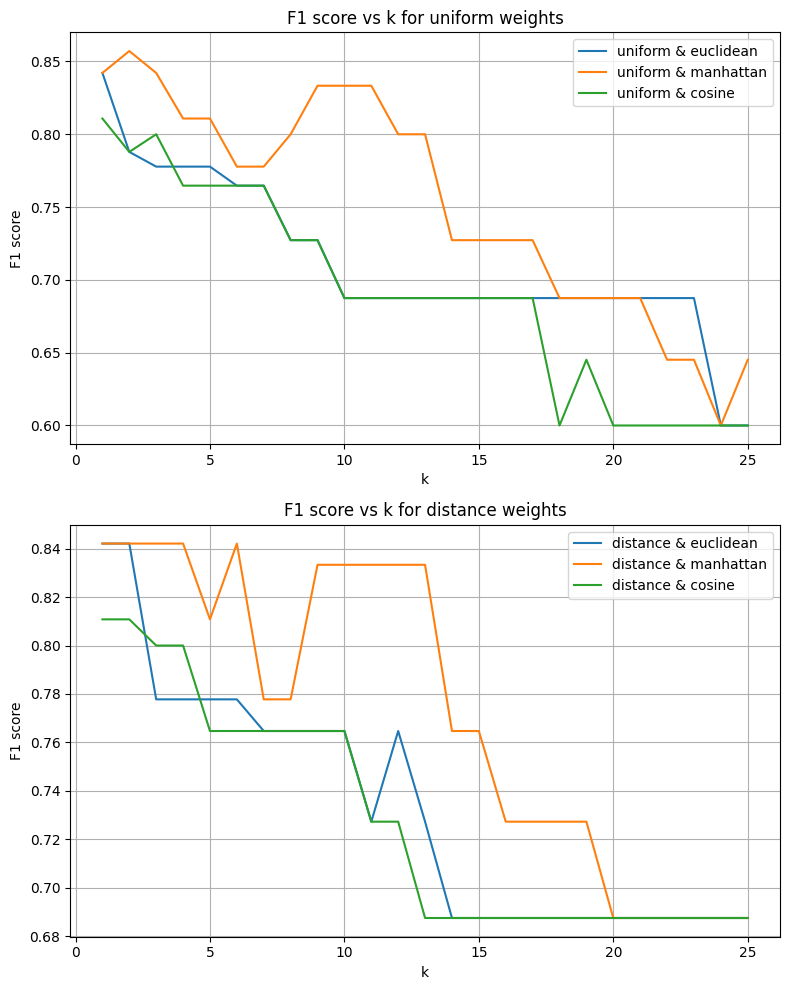

In [36]:
# Plot F1 score vs k different weights and metrics
# Create a figure with 2 subplots for better readability
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

for ax, weight in enumerate(weights):
        for metric in metrics:
            axs[ax].plot(df_evaluation_knn[(df_evaluation_knn['weight'] == weight)&(df_evaluation_knn['metric'] == metric)]['k'], df_evaluation_knn[(df_evaluation_knn['weight'] ==  weight)&(df_evaluation_knn['metric'] == metric)]['f_one_score'], label=f'{weight} & {metric}')
            axs[ax].set_xlabel('k')
            axs[ax].set_ylabel('F1 score')
            axs[ax].set_title(f'F1 score vs k for {weight} weights')
            axs[ax].grid()
            axs[ax].legend()

plt.tight_layout()  # ensures proper spacing between subplots
plt.show()

The f1 score is decreasing with k greater than 11 for uniform weights, and for distance weights, the f1 score is decreasing with k greater than 13. Therefore, in the grid search, values from 1 to 15 are used for k.

The Manhattan metric yields better results than the cosine and Euclidean metric. Nevertheless, they also yield f1 scores above 0.7, which is why all three metrics are used for the grid search.

Also, both weights are used for the grid search because they both yield f1 scores above 0.8.

In [37]:
# define the grid of hyperparameters 
knn_params = {'estimator__n_neighbors':range(1,15),'estimator__weights': ['uniform','distance'],'estimator__metric': ['euclidean','manhattan','cosine']}

## Support Vector Machines


Hyperparameters that are used in the following for the SVM:
- Hyperparameters using the linear kernel function : C
- Hyperparameters using the polynomial kernel function: C, degree(d)
- Hyperparameters using the radial basis kernel function: C, gamma

<b> Note: </b>
I want to mention that there is also a hyperparameter class_weight for SVM classifiers, but it's not used here because a balancing of the data will be performed with oversampling in the pipeline of the nested cross validation. Using class_weight = "balanced" on balanced data leads to the same weights for each class, and that is also the case if "balanced" is not used. 
Usually, different imbalance handling methods should be tried, for example, undersampling, oversampling, and SMOTE. Here, only undersampling will be used because of computing time.
When using SMOTE to handle imbalance, it would also make sense to use the class_weight parameter because SMOTE does not perfectly balance the class. The same also applies to undersampling and oversampling by explicitly setting the ratio of the classes not to be equal.

### Linear kernel function

In [38]:
# define empty dataframe
df_evaluation_linear = pd.DataFrame(columns=['f_one_score', 'precision', 'recall', 'c'])

# set the parameters 
Cs =[0.5, 1,5,10,15,20,50,100,150,500,1000,1500]

# for each combination of parameters, calculate the F1 score
for c in Cs:
    
        clf = SVC(C=c, kernel='linear', random_state=random_seed)
        clf.fit(X_train_sc, y_train) # use scaled data
        y_test_pred = clf.predict(X_test_sc)

        # Precision
        precision = ms.precision_score(y_test, y_test_pred, zero_division=1) # set zero_division=1 to avoid warnings

        # Recall
        recall = ms.recall_score(y_test, y_test_pred)

        # F1 measure 
        f_one = ms.f1_score(y_test, y_test_pred)

        # Create a dictionary with the values
        row_dict = {'f_one_score': f_one,
                    'precision': precision,
                    'recall': recall, 
                    'c': c,
                    }
        
        # Concat the row to the DataFrame
        df_evaluation_linear = pd.concat([df_evaluation_linear, pd.DataFrame([row_dict])], ignore_index=True)

In [39]:
# get rows with highest F1 scores
df_evaluation_linear.nlargest(10, 'f_one_score')

,f_one_score,precision,recall,c
2,0.900000,0.900000,0.90,5.0
3,0.900000,0.900000,0.90,10.0
4,0.878049,0.857143,0.90,15.0
5,0.878049,0.857143,0.90,20.0
1,0.871795,0.894737,0.85,1.0
7,0.871795,0.894737,0.85,100.0
8,0.871795,0.894737,0.85,150.0
6,0.850000,0.850000,0.85,50.0
9,0.842105,0.888889,0.80,500.0
10,0.842105,0.888889,0.80,1000.0


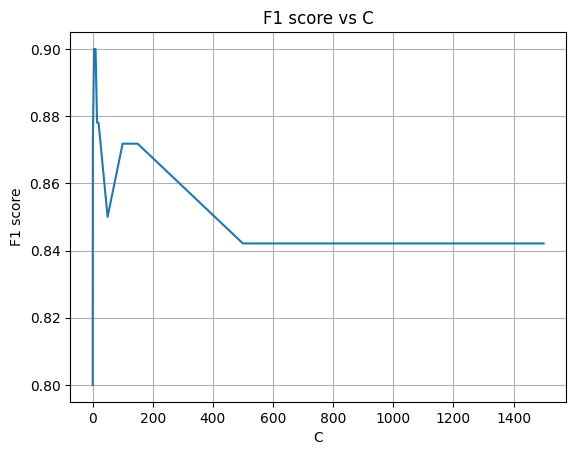

In [40]:
# Plot F1 score vs C 
fig, ax = plt.subplots()
ax.plot(df_evaluation_linear['c'], df_evaluation_linear['f_one_score'])
ax.set_xlabel('C')
ax.set_ylabel('F1 score')
ax.set_title('F1 score vs C')
ax.grid()
plt.show()


The f1 score is the highest for C around 1 and 20 and decreases for values higher 150 and from 500 on it stay constant.
Therfore in the grid search values from 0 to 150 will be considerd. 


In [41]:
# define the grid of hyperparameters 
svm_params_linear = {'estimator__C': [1,5,10,15,20,50,100,150]}

### Polynomial kernel function

In [42]:
# define empty dataframe
df_evaluation_poly = pd.DataFrame(columns=['f_one_score', 'precision', 'recall', 'c', 'degree'])

# set the parameters for polynomial kernel function
degrees = [1, 2, 3, 4]
Cs = [0.005, 0.01, 0.1, 0.5, 1, 3, 5, 10, 100, 150, 200, 500,750,1000]

# for each combination of parameters, calculate the F1 score
for c in Cs:
        for degree in degrees:
                clf = SVC(C=c, kernel='poly', degree= degree, random_state=random_seed)
                clf.fit(X_train_sc, y_train)
                y_test_pred = clf.predict(X_test_sc)

                # Precision
                precision = ms.precision_score(y_test, y_test_pred, zero_division=1) # set zero_division=1 to avoid warnings

                # Recall
                recall = ms.recall_score(y_test, y_test_pred)

                # F1 measure 
                f_one = ms.f1_score(y_test, y_test_pred)

                # Create a dictionary with the values
                row_dict = {'f_one_score': f_one,
                            'precision': precision,
                            'recall': recall, 
                            'c': c,
                            'degree': degree
                            }
                
                # Concat the row to the DataFrame
                df_evaluation_poly = pd.concat([df_evaluation_poly, pd.DataFrame([row_dict])], ignore_index=True)

In [43]:
# get rows with highest F1 scores
df_evaluation_poly.nlargest(5, 'f_one_score')

,f_one_score,precision,recall,c,degree
6,0.9,0.9,0.9,0.01,3
9,0.9,0.9,0.9,0.10,2
13,0.9,0.9,0.9,0.50,2
20,0.9,0.9,0.9,3.00,1
22,0.9,0.9,0.9,3.00,3


In [44]:
def plot_eval_poly(name_metric, name_metric_df):
    """
    Plot evaluation metric vs C for different degrees.
    Args:
        name_metric (string): name of the metric.
        name_metric_df (string): name of the metric in the dataframe.
    Returns:
        None
    """
    
    # set number of columns
    num_cols = 2

    # calculate the number of rows needed
    num_plots = len(degrees)
    num_rows = (num_plots - 1) // num_cols + 1  # Calculate the number of rows required

    # set the desired width and height for the subplots
    subplot_width = 12
    subplot_height = 8

    # calculate the figsize based on the width and height
    fig_width = subplot_width * num_cols
    fig_height = subplot_height * num_rows

    # create the figure with the desired figsize
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


    # iterate over degrees and create plots
    for i, fix_degree in enumerate(degrees):
        # Get the current subplot axis
        ax = axes[i // num_cols, i % num_cols]

        # Plot the data for the current degree
        ax.plot(df_evaluation_poly[(df_evaluation_poly['degree'] == fix_degree)]['c'],
                df_evaluation_poly[(df_evaluation_poly['degree'] == fix_degree)][name_metric_df])


        # Set labels and title
        ax.set_xlabel('C')
        ax.set_ylabel(f'{name_metric}')
        ax.set_title(f'{name_metric} vs C (fix degree = {fix_degree})')
        ax.grid()


    # adjust the layout to avoid overlapping
    plt.tight_layout()

    # display the plot
    plt.show()

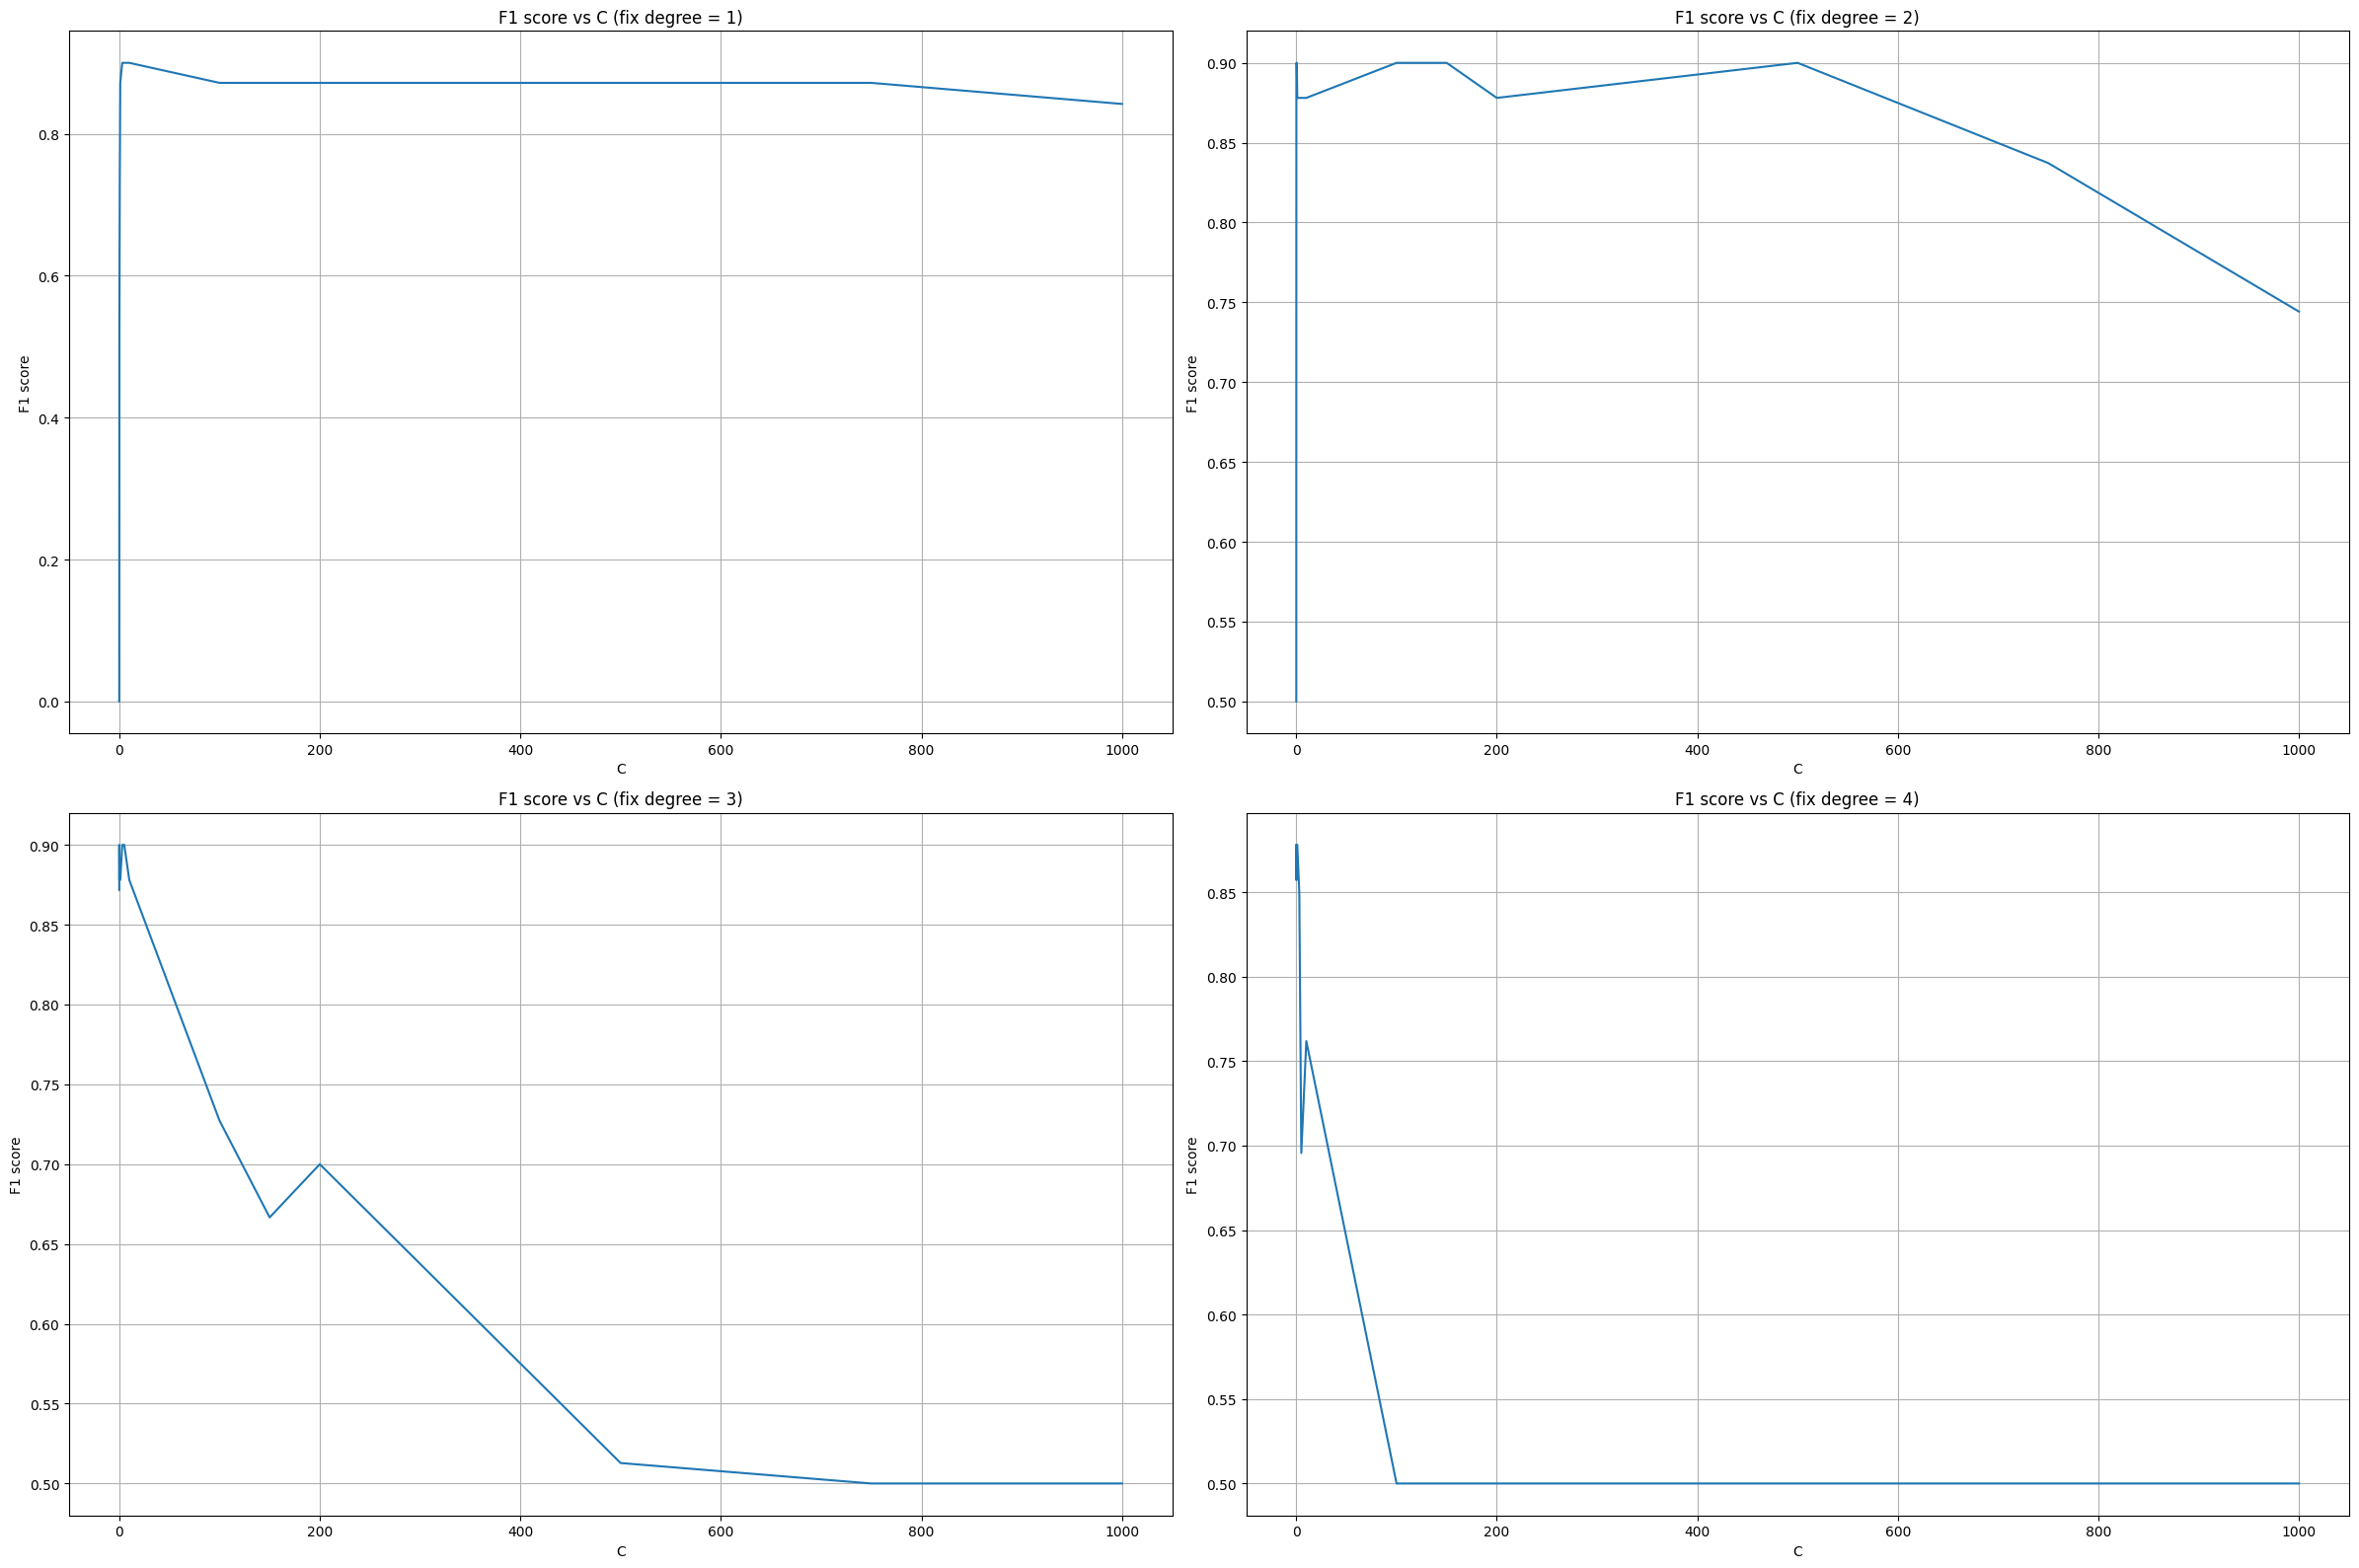

In [45]:
# Plot F1 score vs C for different degrees 
plot_eval_poly('F1 score', 'f_one_score')

For degree 1, the F1 score decreases with values for C above 750.  For degree 2, the F1 score decreases already for values of C larger than 500.
For degrees 3 and 4, the F1 score is highest for values of C between 0.01 and 10 and decreases for values of C above 10.
For the grid search, degrees 1 to 4 will be used because they all lead to f1 scores above 0.8, and to cover the C values where the SVM performed best for each degree, values from 0.01 to 500 will be used for C in the grid search.


In [46]:
# define the grid of hyperparameters 
svm_params_poly = {'estimator__C':[0.01, 0.1, 0.5, 1, 3, 5, 10, 100, 150, 200, 500], 'estimator__degree': [2, 3, 4]}

### Radial basis kernel function (rbf)

In [47]:
# define empty dataframe
df_evaluation_rbf = pd.DataFrame(columns=['f_one_score', 'precision', 'recall', 'c', 'gamma'])

# set the parameter for rbf kernel function
gammas = [0.05, 0.5, 1, 2, 3, 4]
Cs = [0.05, 0.1, 0.5, 1, 3, 5, 10, 100, 150]

# for each combination of parameters, calculate the F1 score
for c in Cs:
        for gamma in gammas:
            clf = SVC(C=c, kernel='rbf', gamma=gamma, random_state=random_seed)
            clf.fit(X_train_sc, y_train)
            y_test_pred = clf.predict(X_test_sc)

            # Precision
            precision = ms.precision_score(y_test, y_test_pred, zero_division=1) # set zero_division=1 to avoid warnings

            # Recall
            recall = ms.recall_score(y_test, y_test_pred)

            # F1 measure 
            f_one = ms.f1_score(y_test, y_test_pred)

            # Create a dictionary with the values
            row_dict = {'f_one_score': f_one,
                        'precision': precision,
                        'recall': recall,
                        'c': c,
                        'gamma': gamma
                        }
            
            # Concat the row to the DataFrame
            df_evaluation_rbf = pd.concat([df_evaluation_rbf, pd.DataFrame([row_dict])], ignore_index=True)

In [48]:
# get rows with highest F1 scores
df_evaluation_rbf.nlargest(10, 'f_one_score')

,f_one_score,precision,recall,c,gamma
31,0.900000,0.900000,0.90,5.0,0.50
36,0.900000,0.900000,0.90,10.0,0.05
42,0.900000,0.900000,0.90,100.0,0.05
37,0.878049,0.857143,0.90,10.0,0.50
48,0.878049,0.857143,0.90,150.0,0.05
19,0.871795,0.894737,0.85,1.0,0.50
25,0.871795,0.894737,0.85,3.0,0.50
39,0.833333,0.937500,0.75,10.0,2.00
43,0.833333,0.937500,0.75,100.0,0.50
20,0.810811,0.882353,0.75,1.0,1.00


In [49]:
def plot_eval_rbf(name_metric, name_metric_df):
    """
    Plot evaluation metric vs C for different gammas 
    Args:
        name_metric (string): name of the metric.
        name_metric_df (string): name of the metric in the dataframe.
    Returns:
        None
    """

    #set number of columns
    num_cols = 2

    # Calculate the number of rows needed
    num_plots = len(gammas)
    num_rows = (num_plots - 1) // num_cols + 1  # Calculate the number of rows required

    # Set the desired width and height for the subplots
    subplot_width = 12
    subplot_height = 8

    # Calculate the figsize based on the width and height
    fig_width = subplot_width * num_cols
    fig_height = subplot_height * num_rows

    # Create the figure with the desired figsize
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


    # Iterate over gammas and create plots
    for i, fix_gamma in enumerate(gammas):
        # Get the current subplot axis
        ax = axes[i // num_cols, i % num_cols]

        # Plot the data for the current gamma
        ax.plot(df_evaluation_rbf[df_evaluation_rbf['gamma'] == fix_gamma]['c'],
                df_evaluation_rbf[df_evaluation_rbf['gamma'] == fix_gamma][name_metric_df],
                )

        # Set labels and title
        ax.set_xlabel('C')
        ax.set_ylabel(f'{name_metric}')
        ax.set_title(f'{name_metric} vs C (fix gamma = {fix_gamma})')
        ax.grid()

    # Adjust the layout to avoid overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


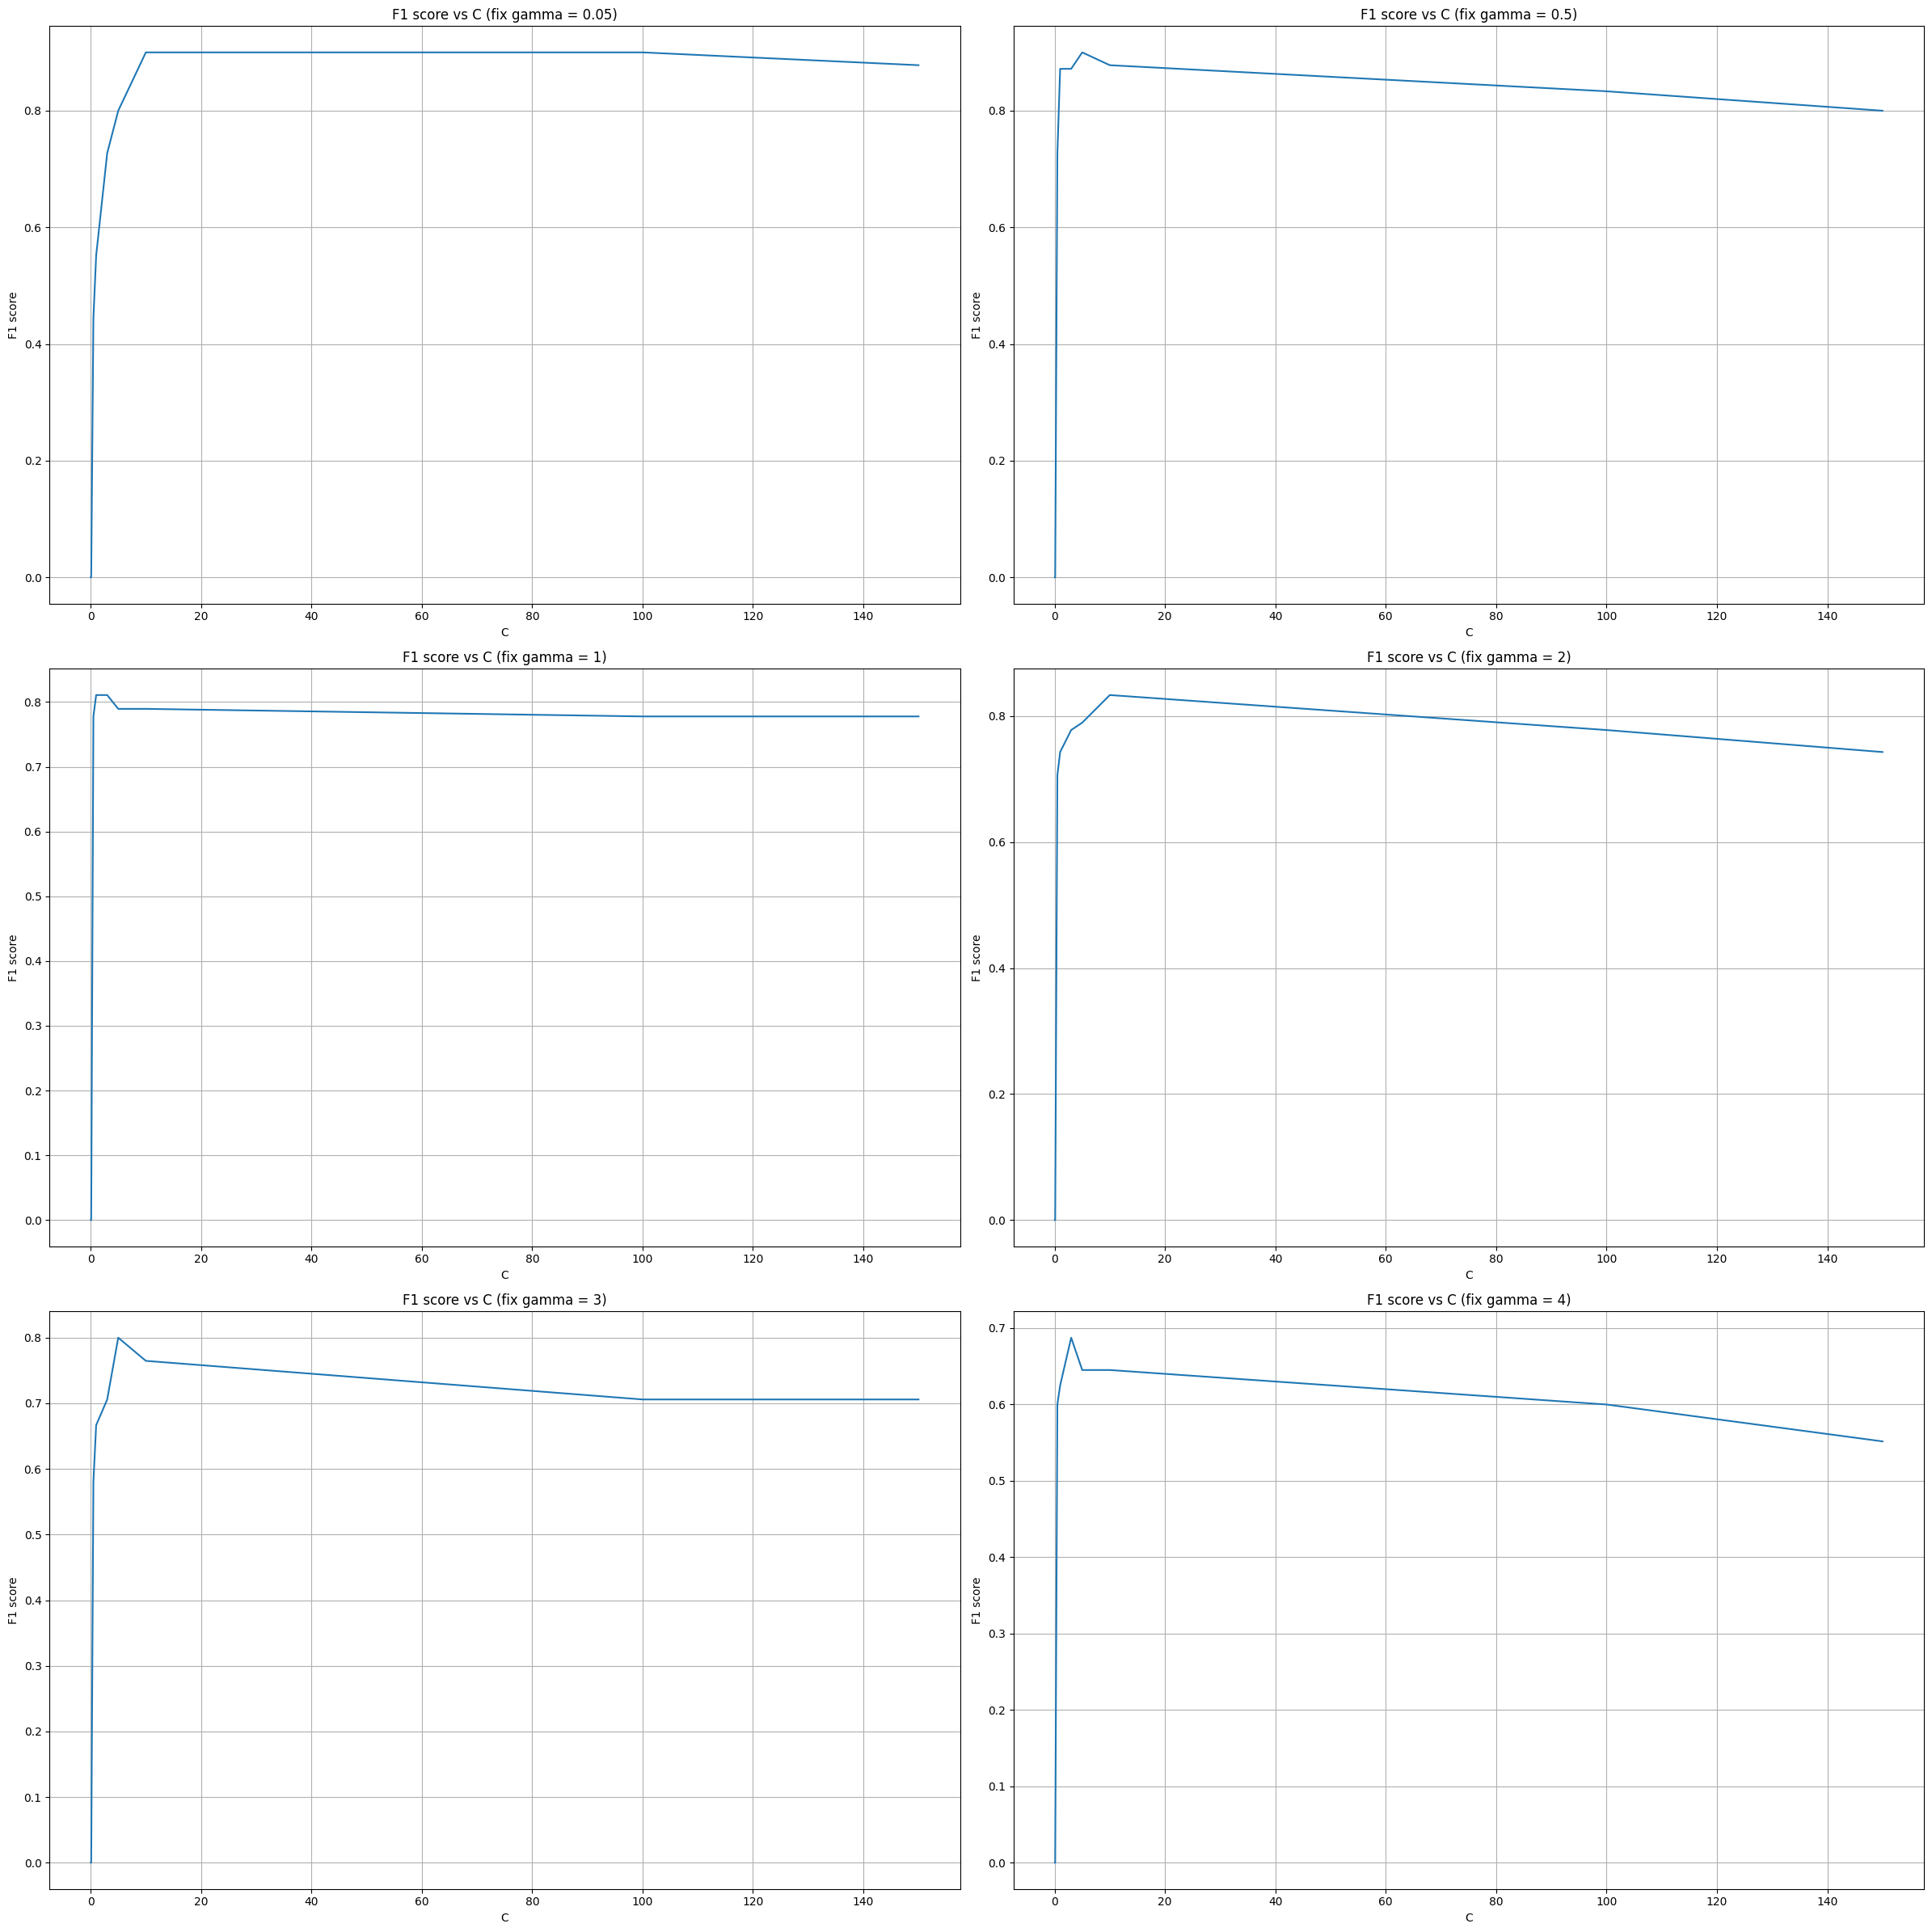

In [50]:
#Plot F1 score vs C for different gammas
plot_eval_rbf('F1 score', 'f_one_score')

For each of the six gamma values that have been tried, the f1 score decreases for higher values of C.
For gamma equal to 0.05 it decreases slowly for higher values of C.
For gamma equal to 3, it decreases for C greater than 10 and stays constant for C greater than 100.
Except for gamma equal to 0.05, the highest f1 score is achieved for C around 1 to 20. For gamma equal to 0.05, the highest f1 score is achieved for values of C around 10 to 100. 
So values from 0.05 to 100 will be tried for C in the grid search.
For all gammas except for 4, the f1 score exceeds 0.7. Therefore, gamma equal to 4 is not used in the grid search. 

In [51]:
# define the grid of hyperparameters 
svm_params_rbf = {'estimator__C': [0.05, 0.1, 0.5, 1, 3, 5, 10, 100], 'estimator__gamma': [0.05, 0.5, 1, 2, 3]}

# Task 7 – Nested Cross Validation

In [52]:
# create a data frame with columns for evaluation metrics values
df_results = pd.DataFrame(columns=['name_clf', 'f_one_test_mean', 'f_one_train_mean', 'f_one_std', 'f_one_min', 'f_one_max', 
                                   'precision_mean', 'precision_std', 'precision_min', 'precision_max',
                                   'recall_mean', 'recall_std', 'recall_min', 'recall_max',
                                   'bal_acc_mean', 'bal_acc_std', 'bal_acc_min', 'bal_acc_max',
                                   'avg_learn_time', 'avg_pred_time'])

In [53]:
def report_metrics(scores, name_clf=None ):
    '''
    Calculates the mean for f1 score, standard deviation, precision, recall, 
    and balanced accuracy, the min and max of the evaluation metrics,
    the learning and predicting time and adds them all to a dataframe.
    Args:
        scores (dict): dictionary with the evaluation metrics.
        name_clf (string): name of the classifier.
    Returns:
        None
    '''
    f_ones_test = scores['test_f1']
    f_ones_train = scores['train_f1']
    precisions = scores['test_precision']
    recalls = scores['test_recall']
    bal_accuracies = scores['test_balanced_accuracy']
    learning_times = np.array([est.refit_time_ for est in scores['estimator']])  # offline time
    prediction_times = np.array([est.score(features, target) for est in scores['estimator']])  # online time
    

    #add row to dataframe results
    new_row = [name_clf, np.mean(f_ones_test), np.mean(f_ones_train), np.std(f_ones_test), np.min(f_ones_test), np.max(f_ones_test),
               np.mean(precisions), np.std(precisions), np.min(precisions), np.max(precisions),
               np.mean(recalls), np.std(recalls), np.min(recalls), np.max(recalls),
               np.mean(bal_accuracies), np.std(bal_accuracies), np.min(bal_accuracies), np.max(bal_accuracies),
               np.mean(learning_times), np.mean(prediction_times)]
    df_results.loc[len(df_results)] = new_row

In [54]:
#set number of inner and outer splits
n_outer_splits = 10 # number of outer splits
n_inner_splits = 10 # number of inner splits

In [55]:
def evaluate_classifier(estimator, grid_params, X=features, y=target, name_clf=None):
    '''
    Evaluates a classifier with nested cross validation.
    Args: 
        estimator (sklearn estimator): classifier to be evaluated.
        grid_params (dict): dictionary with the hyperparameters to be tested.
        X (pandas dataframe): features.
        y (pandas series): target.
        name_clf (string): name of the classifier.
    Returns:
        scores (dict): dictionary with the evaluation metrics.
    '''

    start_time =time.time() # start time for runtime measurement

    #use StratifiedKFold without and not RepeatedStratifiedKFold because of limited computational resources
    outer_cv = StratifiedKFold(n_splits=n_outer_splits, random_state=random_seed, shuffle=True)

    #use StratifiedKFold without and not RepeatedStratifiedKFold because of limited computational resources
    inner_cv = StratifiedKFold(n_splits=n_inner_splits, random_state=random_seed, shuffle=True)

    # create pipeline
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()), # scale data with MinMaxScaler
        ('undersample', RandomUnderSampler(random_state=random_seed)),   # use undersample to handle class imbalance
        ('estimator', estimator) 
    ])

    # grid search for hyperparameter optimization
    grid_search = GridSearchCV(estimator=pipeline, param_grid=grid_params, scoring ="f1", n_jobs=-1, cv=inner_cv)

    #cross validation for evaluation and comparison
    scores = cross_validate(estimator=grid_search, X=X, y=y, scoring =("f1","precision","recall","balanced_accuracy"), cv=outer_cv, n_jobs=-1,return_train_score=True, return_estimator=True)
    
    end_time = time.time() # end time for runtime measurement
    print(f"Ncv runtime for {name_clf}:", end_time - start_time) # print runtime

    report_metrics(scores, name_clf)

    return(scores)

<b> Note: </b> 
In Task 8, the full data set is used. This is possible at a reasonable runtime on my computer because undersampling is used during cross validation to handle the class imbalance.
The side effect of undersampling is that by droping instances of the larger class, the data set becomes smaller, and so the computational effort is reduced.
Usually, other methods should be tested to handle class imbalance, like oversampling or SMOTE.
And with many features, the computational effort could be reduced by using PCA in the pipeline.

Using RepeatedStratifiedKFold instead of StratifiedKFold could help reduce the variance of the evaluation. Therefore, it's recommended to use it. Here, it's not used to improve the runtime. 


##### Decision Tree:

In [56]:
# initialize decision tree classifier
dt_clf = tree.DecisionTreeClassifier(random_state =random_seed)
dt_scores = evaluate_classifier(estimator=dt_clf, grid_params=dt_params, name_clf='DT')

Ncv runtime for DT: 255.71676397323608


##### KNN:

In [57]:
# initialize knn classifier
knn_clf = KNeighborsClassifier(algorithm="auto",n_jobs=-1)
knn_scores = evaluate_classifier(estimator=knn_clf, grid_params=knn_params, name_clf='KNN')

Ncv runtime for KNN: 6500.730567455292


##### SVM linear:

In [58]:
# initialize svm classifier with linear kernel
svc_linear_clf = SVC(kernel = 'linear', random_state =random_seed)
svc_linear_scores = evaluate_classifier(estimator=svc_linear_clf, grid_params=svm_params_linear, name_clf='SVC_linear')

Ncv runtime for SVC_linear: 186.52339816093445


##### SVM polynomial:

In [59]:
# initialize svm classifier with polynomial kernel
svm_poly_clf = SVC(kernel = 'poly', random_state =random_seed)
svc_poly_scores = evaluate_classifier(estimator=svm_poly_clf, grid_params=svm_params_poly, name_clf='SVC_poly')

Ncv runtime for SVC_poly: 787.7612285614014


##### SVM rbf:

In [60]:
# initialize svm classifier with rbf kernel
svm_rbf_clf = SVC(kernel = 'rbf', random_state =random_seed)
svc_rbf_scores = evaluate_classifier(estimator=svm_rbf_clf, grid_params=svm_params_rbf,  name_clf='SVC_rbf')


Ncv runtime for SVC_rbf: 2989.123329639435


In [61]:
# display results
df_results_rounded = df_results.round(3) # round values
df_results_rounded

,name_clf,f_one_test_mean,f_one_train_mean,f_one_std,f_one_min,f_one_max,precision_mean,precision_std,precision_min,precision_max,recall_mean,recall_std,recall_min,recall_max,bal_acc_mean,bal_acc_std,bal_acc_min,bal_acc_max,avg_learn_time,avg_pred_time
0,DT,0.086,0.089,0.056,0.033,0.201,0.047,0.032,0.017,0.116,0.874,0.056,0.776,1.00,0.911,0.019,0.883,0.953,0.405,0.089
1,KNN,0.367,0.365,0.038,0.307,0.422,0.234,0.030,0.186,0.274,0.858,0.040,0.796,0.92,0.926,0.020,0.896,0.958,0.494,0.365
2,SVC_linear,0.427,0.428,0.079,0.350,0.630,0.289,0.073,0.218,0.479,0.856,0.041,0.776,0.92,0.926,0.021,0.886,0.959,0.468,0.428
3,SVC_poly,0.769,0.765,0.042,0.699,0.843,0.743,0.064,0.646,0.827,0.803,0.051,0.720,0.86,0.901,0.025,0.860,0.930,0.475,0.766
4,SVC_rbf,0.805,0.806,0.040,0.737,0.875,0.846,0.044,0.761,0.913,0.768,0.043,0.700,0.84,0.884,0.021,0.850,0.920,0.524,0.806


In [62]:
# show the basline results
print(f'Basline f1 score: {round(f_one_baseline,3)}, Basline precision: {round(precision_baseline,3)}, Basline recall: {round(recall_baseline,3)}, Basline balanced accuracy: {round(balanced_acc_baseline,3)}')

Basline f1 score: 0.003, Basline precision: 0.002, Basline recall: 0.5, Basline balanced accuracy: 0.499


<b> Compare the classifiers based on the F1 score, precision, and recall: </b> 
All five classifiers perform better than the baseline classifier, according to the mean of the F1 score. Comparing the mean f1 score for training and testing, it's clear that they are almost the same and only differ in the third decimal place. That's an indicator that they do not overfit. 
The decision tree classifier has the worst f1 score mean, followed by the KNN classifier, and then the SVM classifier with a linear kernel function. The three all have a mean f1 score below 0.45, which is not enough to use them in production.
The SVM classifier with a polynomial kernel and the SVM classifier with rbf kernel performed way better, with mean f1 scores above 0.75. So their performance will be investigated more closely.
SVC_poly and SVC_rbf both have a little standard deviation that only differs in the third decimal place. The minimum and maximum f1 scores are slightly higher for SVC_rbf than for SVC_poly.
By looking at the precision, it can be seen that SVC_poly has a lower precision mean than SVC_rbf. The absolute difference between the two precision values is 0.103.
That means that the number of elements that SVC_poly identified as being of class $C_i$ that were actually of class $C_i$ is lower than for SVC_rbf.  
The mean recall is higher for SVC_poly than for SVC_rbf, so the number of elements of class $C_i$ that have been recognized as $C_i$ is lower for SVC_rbf than for SVC_poly. The absolute difference in the two recalls is 0.035. 

<b>Compare the classifiers based on balanced accuracy:</b>
Because the dataset is highly imbalanced, balanced accuracy is not the best metric to compare and evaluate the classifiers.
That's because it treats all classes equally, regardless of their frequency in the dataset. So the majority class dominates the evaluation, and that leads to misleading results for highly imbalanced datasets.
Nevertheless, all classifiers have a mean balanced accuracy above 0.8, and therefore they perform better than the baseline classifier according to the balanced accuracy.

<b>Compare the classifiers based on the average learning and prediction time:</b>
The decision tree classifier has the lowest average learning and prediction time, but also the lowest f1 score mean.
The longest average learning time has the kNN classifier, and the longest average prediction time has the SVC with rbf kernel.
Comparing SVC_poly and SVC_rbf, the average learning and prediction time is ~0.04 lower for SVC_poly. Always keep in mind that the learning and prediction times are influenced by several factors, like hardware and utilization.

<b> Recommendation: </b> 
Over all, the SVM with a polynomial kernel and a radial basis function kernel performed the best. SVC_rbf has a higher mean f1 score but also a slightly higher average prediction time.
Because the bank I am working for values more the performance than the learning time, I would recommend using an SVM with a radial basis kernel function.


# Task 8 – Final Production Model

In [63]:
# set number of splits and repeats for cv
n_splits = 10
n_repeats = 5

In [64]:
# determine the best hyperparameters for chosen classifiers
def train_prod_model(estimator, grid_params):
    '''
    Trains a classifier with nested cross validation.
    Args:
        estimator (sklearn estimator): classifier to be evaluated.
        grid_params (dict): dictionary with the hyperparameters to be tested.
    Returns:
        clf (sklearn estimator): classifier with best hyperparameters.
    '''

    # use undersample to handle class imbalance
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()), # scale data with MinMaxScaler
        ('undersample', RandomUnderSampler(random_state=random_seed)),   # use undersample to handle class imbalance
        ('estimator', estimator) 
    ])

    # repeated cross validation  loop for paramerer optimization  (Stratified!)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_seed)

    # grid search for hyperparameter optimization
    clf = GridSearchCV(estimator=pipeline, param_grid=grid_params, scoring ="f1", n_jobs=-1, cv=cv)

    clf.fit(features,target)# use the full data for training. 
    return clf 

# define grid of hyperparameters 
svm_params_rbf = {'estimator__C': [0.05, 0.1, 0.5, 1, 3, 5, 10, 100, 150],
 'estimator__gamma': [0.05, 0.5, 1, 2, 3, 4]}


# do cross validation to find the best hyperparameters for the SVM classifier with rbf kernel
best_clf = train_prod_model(estimator=svm_rbf_clf , grid_params= svm_params_rbf) 

In [65]:
# print the best estimator
print(best_clf.best_estimator_)
print(f'The hypermarameters for the best SVC_rbf classifier are: {best_clf.best_params_}')

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('undersample', RandomUnderSampler(random_state=1)),
                ('estimator', SVC(C=0.5, gamma=0.05, random_state=1))])
The hypermarameters for the best SVC_rbf classifier are: {'estimator__C': 0.5, 'estimator__gamma': 0.05}


In [66]:
# store the model 
joblib.dump(best_clf, 'fraud_clf.pkl')

# # how to load the model and use it:
# loaded_model = joblib.load('fraud_clf.pkl')
# predictions = loaded_model.predict(X_new) # X_new is the new data to be classified


['fraud_clf.pkl']

# Task 9 – Conclusions and Future Work

<b> Conclusion: </b>
In this experiment, we aimed to detect fraudulent credit card transactions using various approaches, including Decision Tree, kNN, and SVMs with linear, polynomial, and radial basis kernel. Each classifier was optimized for the task, and their results were compared to select the best one. The SVM with a radial basis kernel function outperformed the others, achieving a mean f1 score of 0.8. Therefore, this classifier was chosen to possibly be used in production. Therefore, the hyperparameters were optimized and then trained with the full data set.

However, it should be noted that the performance of the classifier trained on the full dataset cannot be evaluated due to the lack of additional data for testing. We assume a similar performance as observed during nested cross validation, expecting a f1 score of 0.8 with a standard deviation of 0.04. 

As a data scientist, it is crucial to collaborate with the business department to determine if this performance is satisfactory for the task at hand. Factors such as the potential damage to the bank in the event of undetected fraudulent transactions and the impact on customer satisfaction if non-fraudulent transactions are wrongly identified as fraudulent need to be considered. Striking the right balance between detecting fraud, saving money, and maintaining customer satisfaction is important here.

<b> Future work: </b>
To enhance the classifier's performance, future work should involve exploring different methods for handling class imbalance, such as undersampling and SMOTE in combination with repeated nested cross validation. Additionally, ensemble methods like bagging or boosting could be employed. These approaches may further improve the f1 score and ensure more reliable and generalizable results.

The outcome of this experiment is promising, as it enables the bank to detect fraudulent transactions, thereby saving money and enhancing customer satisfaction. However, before deploying the classifier, its performance on new and unseen data needs to be thoroughly evaluated. A continuous monitoring and improvement are necessary to ensure effective fraud detection.
 